# Lesson 4: Working with Raster data

- https://kodu.ut.ee/~kmoch/geopython2019/L4/raster.html

In [1]:
import rasterio
dataset = rasterio.open('forest_loss_porijogi_wgs84.tif')

In [2]:
print(dataset.name)
print(dataset.mode)
print(dataset.count)
print(dataset.width)
print(dataset.height)
print(dataset.crs)
print(dataset.bounds)

forest_loss_porijogi_wgs84.tif
r
1
1326
687
EPSG:4326
BoundingBox(left=26.548502689, bottom=58.117685726, right=26.880002689, top=58.289435726)


In [3]:
print(dataset.profile)

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': 128.0, 'width': 1326, 'height': 687, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002500000000000014, 0.0, 26.548502689,
       0.0, -0.0002500000000000043, 58.289435726), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


In [4]:
print(dataset.transform)

| 0.00, 0.00, 26.55|
| 0.00,-0.00, 58.29|
| 0.00, 0.00, 1.00|


In [5]:
for i in range(len(dataset.indexes) ):
    print("{}: {}".format(i, dataset.dtypes[i]))


0: int16


In [6]:
# reading the first band (not from zero!)
band1 = dataset.read(1)

band1

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0, 17, 17, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int16)

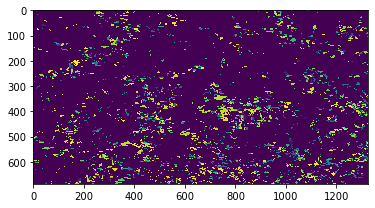

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(band1)

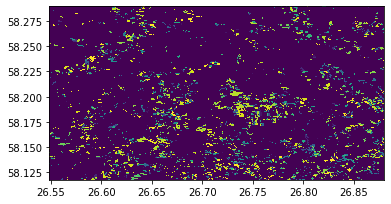

In [8]:
from rasterio.plot import show

show(dataset)

In [9]:
import numpy as np

# get classes
uniq_vals = np.unique(band1)

# display sorted order
print(sorted(uniq_vals))  

# Patches = the matplotlib objects drawn
counts, bins = np.histogram(band1, bins=18)

# Print histogram outputs
for i in range(len(bins)-1):
    print("bin lower bound:", bins[i])
    print("counts:", counts[i])


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
bin lower bound: 0.0
counts: 815440
bin lower bound: 1.0
counts: 4269
bin lower bound: 2.0
counts: 4179
bin lower bound: 3.0
counts: 1076
bin lower bound: 4.0
counts: 3273
bin lower bound: 5.0
counts: 4023
bin lower bound: 6.0
counts: 4418
bin lower bound: 7.0
counts: 3327
bin lower bound: 8.0
counts: 4611
bin lower bound: 9.0
counts: 3576
bin lower bound: 10.0
counts: 3983
bin lower bound: 11.0
counts: 5469
bin lower bound: 12.0
counts: 3706
bin lower bound: 13.0
counts: 2764
bin lower bound: 14.0
counts: 5237
bin lower bound: 15.0
counts: 6990
bin lower bound: 16.0
counts: 13465
bin lower bound: 17.0
counts: 21156


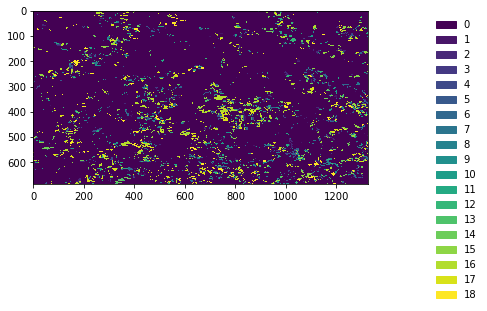

In [10]:
from matplotlib.patches import Patch
from matplotlib.colors import BoundaryNorm
from matplotlib import rcParams, cycler

fig, ax = plt.subplots()

cmap = plt.cm.viridis
lst = [int(x) for x in np.linspace(0,255,19)]
legend_patches = [Patch(color=icolor, label=label) for icolor, label in zip( cmap(lst), sorted(uniq_vals))]

ax.legend(handles=legend_patches,
          facecolor="white",
          edgecolor="white",
          bbox_to_anchor=(1.35, 1))

plt.imshow(band1, cmap=cmap, interpolation='nearest')


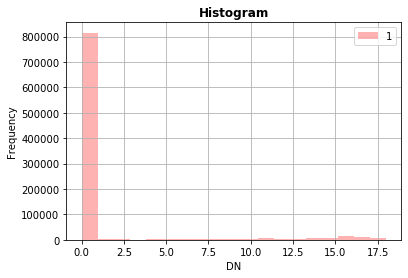

In [11]:
from rasterio.plot import show_hist

show_hist(dataset, bins=19, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram")

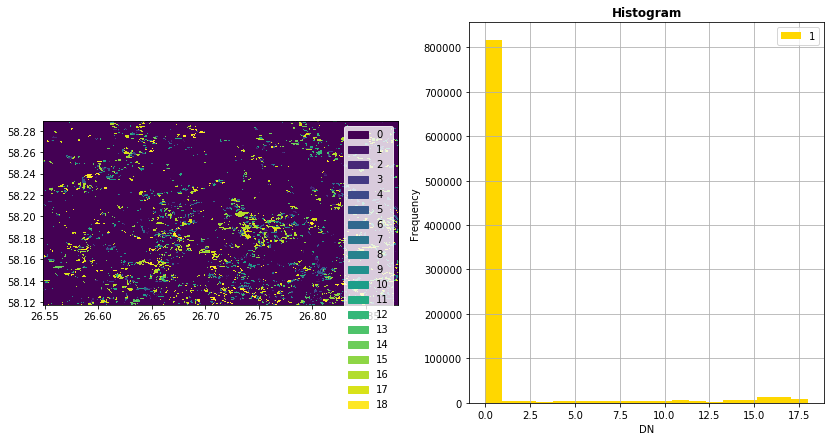

In [12]:
fig, (ax_dat, ax_hist) = plt.subplots(1, 2, figsize=(14,7))

ax_dat.legend(handles=legend_patches, facecolor="white", edgecolor="white")

show((dataset, 1), ax=ax_dat)

show_hist((dataset, 1), bins=19, ax=ax_hist)

plt.show()

dataset.close()

## Reproject a raster from one EPSG-code to another

In [13]:
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:3301'

with rasterio.open('forest_loss_porijogi_wgs84.tif') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open('forest_loss_porijogi_3301.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

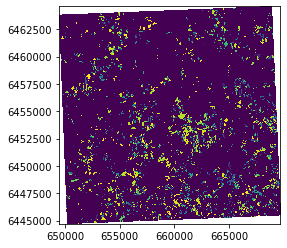

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': 128.0, 'width': 1107, 'height': 1088, 'count': 1, 'crs': CRS.from_epsg(3301), 'transform': Affine(18.286653237913317, 0.0, 649439.5163138957,
       0.0, -18.286653237913317, 6464597.241364011), 'tiled': False, 'interleave': 'band'}

In [14]:
with rasterio.open('forest_loss_porijogi_3301.tif', 'r') as data2:
    show(data2, cmap=cmap)
    display(data2.profile)

## Clipping a raster

In [15]:
import geopandas as gpd

catchments = gpd.read_file('porijogi_sub_catchments.geojson')

display(catchments.crs)
display(catchments.head(5))

{'init': 'epsg:3301'}

,OBJECTID,NAME_1,AREA_1,Shape_Leng,Shape_Area,ID,geometry
0,8,Idaoja,3823.427995,35446.162219,3.823428e+07,1,"MULTIPOLYGON (((660834.858 6455555.914, 660851..."
1,9,Keskjooks,5087.809731,42814.174755,5.087810e+07,2,"MULTIPOLYGON (((666339.502 6455972.600, 666384..."
2,10,Peeda,5634.162684,47792.268153,5.634163e+07,3,"MULTIPOLYGON (((659914.002 6456514.131, 659817..."
3,11,Sipe,890.280919,16449.028656,8.902809e+06,4,"MULTIPOLYGON (((665928.914 6460634.243, 665985..."
4,12,Tatra,3306.643841,31108.960376,3.306644e+07,5,"MULTIPOLYGON (((658678.470 6457825.152, 658579..."


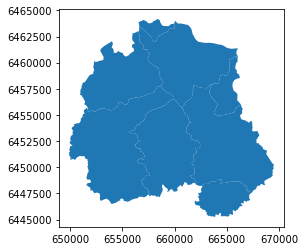

In [16]:
catchments.plot()

In [17]:
import fiona 

with fiona.open("porijogi_sub_catchments.geojson", "r") as vectorfile:
    shapes = [feature["geometry"] for feature in vectorfile]


In [18]:
from rasterio.mask import mask

data2 = rasterio.open('forest_loss_porijogi_3301.tif', 'r')

# Clip the raster with Polygon
out_image, out_transform = mask(dataset=data2, shapes=shapes, crop=True)

out_meta = data2.meta.copy()

data2.close()

In [19]:
out_meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': 128.0,
 'width': 1107,
 'height': 1088,
 'count': 1,
 'crs': CRS.from_epsg(3301),
 'transform': Affine(18.286653237913317, 0.0, 649439.5163138957,
        0.0, -18.286653237913317, 6464597.241364011)}

In [20]:
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open("forest_loss_clipped.tif", "w", **out_meta) as dest:
    dest.write(out_image)

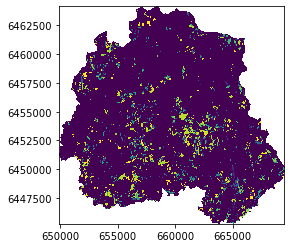

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': 128.0, 'width': 1072, 'height': 1034, 'count': 1, 'crs': CRS.from_epsg(3301), 'transform': Affine(18.286653237913317, 0.0, 649896.6826448436,
       0.0, -18.286653237913317, 6464158.3616863005), 'tiled': False, 'interleave': 'band'}

In [21]:
with rasterio.open("forest_loss_clipped.tif", "r") as data3:
    show(data3)
    display(data3.profile)


## Calculating zonal statistics

In [22]:
import geopandas as gpd

catchments = gpd.read_file('porijogi_sub_catchments.geojson')

In [23]:
demdata = rasterio.open('dem.tif')

print(demdata.name)
print(demdata.mode)
print(demdata.count)
print(demdata.width)
print(demdata.height)
print(demdata.crs)
print(demdata.bounds)


dem.tif
r
1
1020
1065
EPSG:3301
BoundingBox(left=644405.5556, bottom=6443988.8889, right=675000.5556, top=6475948.8889)


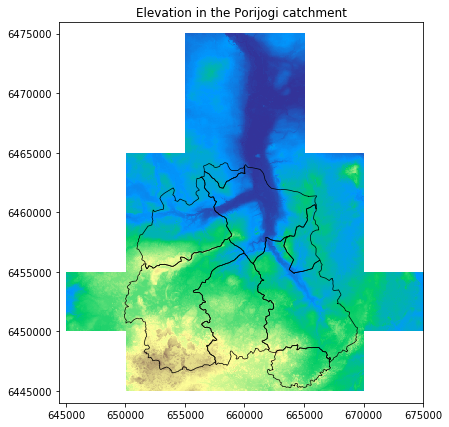

In [24]:
fig, ax = plt.subplots(1, figsize=(9, 7))

show((demdata, 1), cmap='terrain', interpolation='none', ax=ax)

catchments.plot(ax=ax, facecolor="none", edgecolor='black', lw=0.7)

plt.title("Elevation in the Porijogi catchment")

plt.show()

In [25]:
from rasterstats import zonal_stats

zs = zonal_stats('porijogi_sub_catchments.geojson', 'dem.tif', stats=['mean','std'])
display(zs)

[{'mean': 108.81127854956439, 'std': 20.45245360418255},
 {'mean': 86.88054631660887, 'std': 16.95209830197268},
 {'mean': 122.27791004234241, 'std': 25.821034407200845},
 {'mean': 76.41216968715197, 'std': 6.690340937594575},
 {'mean': 82.89976042687574, 'std': 23.864544169477856},
 {'mean': 66.31877151178183, 'std': 6.77909304322478},
 {'mean': 112.26344569806881, 'std': 15.545179792343868},
 {'mean': 59.404531339850486, 'std': 16.974837452873903}]

In [26]:
import pandas as pd

demstats_df = pd.DataFrame(zs)

demstats_df.rename(columns={'mean':'dem_mean','std':'dem_std'}, inplace=True)

catchments = pd.concat([catchments, demstats_df], axis=1)

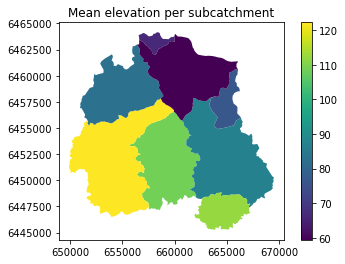

In [27]:
fig, ax = plt.subplots(1, 1)

plt.title("Mean elevation per subcatchment")

catchments.plot(column='dem_mean', ax=ax, legend=True)